



Patrícia H Nallin

novembro/2023


--------

# Comunicações Digitais
## Objetivos

1. Enviar uma mensagem de texto via modulação FSK, cuja frequência do sinal transmitido corresponde a um símbolo. Os símbolos compõem as representações em binário dos caracteres da mensagem (codificação ASCII). A modulação FSK deverá ter frequências no espectro sonoro, a fim de que o sinal final possa ser armazenado/reproduzido via áudio.



2. Receber a gravação do sinal de áudio e processá-la, de forma a recuperar a mensagem de texto original.


![Diagrama de blocos](imagens/diagrama_blocos.png "Diagrama de blocos")


## Ferramentas de software

Decidiu-se utilizar a linguagem Python para implementação das funcionalidades por prévio conhecimento e por ser uma ferramenta aberta e muito utilizada pela comunidade.
<br><br>

Todos os gráficos apresentados podem ter sua versão interativa acessada pelo arquivo *.html gerado!


#### Módulos Python necessários

In [1]:
import numpy as np
from scipy import signal
from scipy.io import wavfile
import plotly
import plotly.graph_objects as go

## Informações que devem ser conhecidas por ambos, no caso de modulação FSK


- Tempo de duração de um símbolo (Ts)
- Sequencia de treinamento
- Frequências para a portadora
- Alfabeto e mapeamento dos símbolos


No caso, será definido também a taxa de amostragem (amostras por segundo), inerente ao sistema de som utilizado, para a construção dos sinais senoidais de duração Ts.


#### Definições de variáveis comuns para o transmissor e o receptor

In [2]:
sampleRate = 44100 # samples per second - intrinsec to sound system
Ts = 0.05 # seconds - symbol time



plot = True

# ----- SEQUENCER - Sequencia de treinamento
nSequencer = 6
nbitsSequencer = (2**nSequencer) - 1
seq = signal.max_len_seq(nSequencer)[0]
seqStr = '0' + ''.join(chr(i + 48) for i in seq)
seqIntValue = int(seqStr,2)


# ----- FSK - Frequencias de audio para representação dos simbolos
nSymbols = 4
f0 = 440
f1 = 770
f2 = 550
f3 = 660
f = [f0, f1, f2, f3]
t = np.arange(0, Ts, 1/sampleRate)



symbolMapping = {
    # 2 simbolos:
    2: {
        "0":  np.sin(2*np.pi*f0*t),
        "1":  np.sin(2*np.pi*f1*t)
    },    
    # 4 simbolos:
    4: {
        "00": np.sin(2*np.pi*f0*t),
        "01": np.sin(2*np.pi*f1*t),
        "11": np.sin(2*np.pi*f2*t),
        "10": np.sin(2*np.pi*f3*t)
    }
}

receivedSymbolMapping = {
    2: [b'0', b'1'],
    4: [b'00', b'01', b'11', b'10']
}

# Transmissão
Gerar arquivo de áudio a partir da mensagem de texto a ser enviada
---


Definida a mensagem (ou _payload/conteúdo_) a ser enviada, será utilizada a codificação ASCII para mapeamento dos caracteres em bits. Na sequência, percorre-se a cadeia de bits para a construção de uma sequência de sinais senoidais de frequências correspondentes aos valores dos bits (mapeamento dos símbolos).

Esse mapeamento também é realizado para a sequência de treinamento.


In [37]:
# MESSAGE
mensagem = 'Transmissao de dados via FSK'
mensagemBitsStr = ''.join(format(ord(i), '08b') for i in mensagem)




# MAPPING MESSAGE SYMBOLS -> FSK
msgMapped = np.array([])
i=0
while(i < len(mensagemBitsStr)):
    ini = i
    i += int(np.log2(nSymbols))
    end = i

    c = mensagemBitsStr[ini:end]

    if c in symbolMapping[nSymbols].keys():
        msgMapped = np.concatenate((msgMapped, symbolMapping[nSymbols][c]))
    else:
        print("Bit(s) {} not mapped !".format(c))


   

# MAPPING SEQ SYMBOLS -> FSK
seqMapped = np.array([])
i=0
while(i < len(seqStr)):
    ini = i
    i += int(np.log2(nSymbols))
    end = i

    c = seqStr[ini:end]

    if c in symbolMapping[nSymbols].keys():
        seqMapped = np.concatenate((seqMapped, 2*symbolMapping[nSymbols][c]))
    else:
        print("Symbol {} not mapped !".format(c))

        
print("TAMANHO DA MENSAGEM: {} caracteres".format(len(mensagem)))
print("QUANTIDADE DE BITS NA MENSAGEM: {}".format(len(mensagemBitsStr)))
print("QUANTIDADE DE BITS NA SEQ.TREINAMENTO: {}".format(len(seqStr)))

TAMANHO DA MENSAGEM: 28 caracteres
QUANTIDADE DE BITS NA MENSAGEM: 224
QUANTIDADE DE BITS NA SEQ.TREINAMENTO: 64


---
Em seguida, tendo os sinais para a mensagem e sequência de treinamento, é possível concatenar e intercalar ambos a fim de aumentar a robustez na recepção.

Para esta finalidade e exemplificação, escolheu-se repetir o sinal três vezes. Assim, o áudio terá:

*SEQ.TREINAMENTO + **MENSAGEM** + SEQ.TREINAMENTO + **MENSAGEM** + SEQ.TREINAMENTO + **MENSAGEM** + SEQ.TREINAMENTO*

<br>

A adição de um ruído branco ao sinal é opcional. Na sequência, o sinal é ajustado para ser armazenado digitalmente em um arquivo de áudio *.wav com resolução de 16 bits.

In [39]:
# MESSAGE + SEQUENCER
nSequencias = 3 # to repeat payload data
gt = np.array([])

for _ in range(nSequencias):
    gt = np.concatenate((gt, seqMapped, msgMapped))
gt = np.concatenate((gt, seqMapped))



# ADD NOISE, IF WANTED
mean_noise = 0
stdev = 0.75
add_noise = False
if add_noise:
    gt += np.random.normal(mean_noise, stdev, len(gt))

# PLAY AUDIO
#sd.play(gt, blocking=True)


# SAVE AUDIO INTO *.WAV FILE
audioFile = "amostraSom_seq{}_rept{}_nSymbols{}_Ts{}ms.wav".format(nSequencer, nSequencias, nSymbols, int(Ts*1000))
scaled = np.int16(gt / np.max(np.abs(gt)) * 32767)
wavfile.write("audios/" + audioFile, sampleRate, scaled)



print("Total de {} bits mapeados!".format((nSequencias+1)*len(seqStr)+nSequencias*len(mensagemBitsStr)))
print("Arquivo de audio gerado: {}".format(audioFile))

Total de 928 bits mapeados!
Arquivo de audio gerado: amostraSom_seq6_rept3_nSymbols4_Ts50ms.wav


---
##### Gráficos

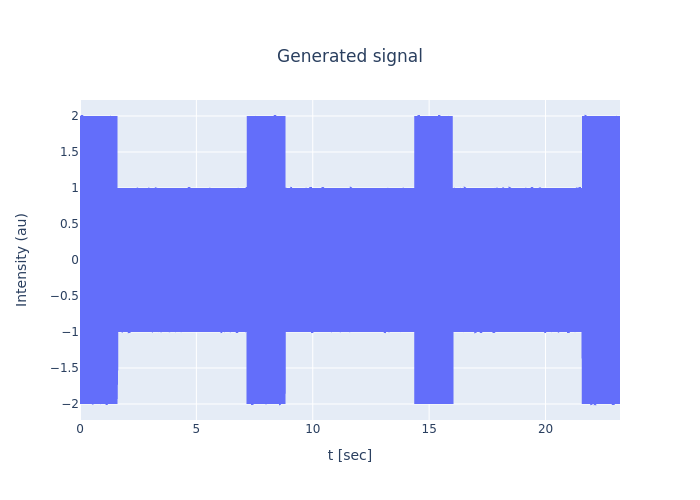

GRAFICO INTERATIVO CORRESPONDENTE: sinal_seq6_rept3_nSymbols4_Ts50ms.html


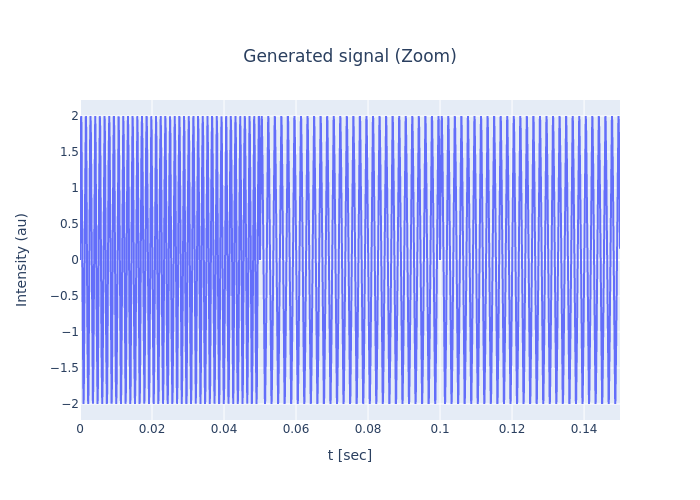

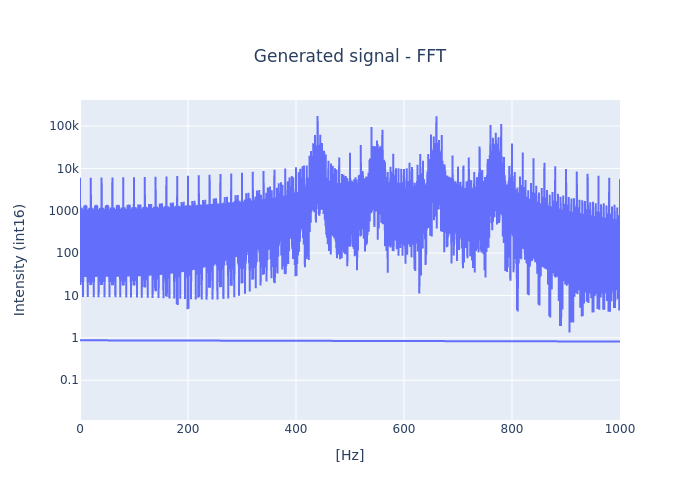

GRAFICO INTERATIVO CORRESPONDENTE: sinal_FFT_seq6_rept3_nSymbols4_Ts50ms.html


In [40]:
if plot:
    
    # SINAL GERADO    
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=gt, x=np.linspace(0, len(gt)/sampleRate, len(gt))))

    fig.update_layout(
        title={
            'text': "Generated signal",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        xaxis_title="t [sec]",
        yaxis_title="Intensity (au)",
    )
    figname = "sinal_seq{}_rept{}_nSymbols{}_Ts{}ms.html".format(nSequencer, nSequencias, nSymbols, int(Ts*1000))
    plotly.offline.plot(fig, filename = "graficos/" + figname, auto_open=False)
    fig.show(renderer="png")
    print("GRAFICO INTERATIVO CORRESPONDENTE: {}".format(figname))
    
    
    # "ZOOM" NO INICIO DO SINAL GERADO
    symbols2show = 3
    tzoom = int(symbols2show*sampleRate*Ts)
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=gt[0:tzoom], x=np.linspace(0, len(gt)/sampleRate, len(gt))[0:tzoom]))

    fig.update_layout(
        title={
            'text': "Generated signal (Zoom)",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        xaxis_title="t [sec]",
        yaxis_title="Intensity (au)",
    )
    fig.show(renderer="png")
    
    
    # FFT DO SINAL
    fftSignal = np.abs(np.fft.fft(gt))
    ft = np.fft.fftfreq(len(gt),1/(sampleRate))
    

    fig = go.Figure()
    fig.add_trace(go.Scatter(y=fftSignal,
                             x=ft,
                        name='fft'))
    fig.update_xaxes(range=[0, 1000])
    fig.update_yaxes(type="log")
    fig.update_layout(
        title={
            'text': "Generated signal - FFT",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        yaxis_title="Intensity (int16)",
        xaxis_title="[Hz]",
    )

    figname = "sinal_FFT_seq{}_rept{}_nSymbols{}_Ts{}ms.html".format(nSequencer, nSequencias, nSymbols, int(Ts*1000))
    plotly.offline.plot(fig, filename = "graficos/" + figname, auto_open=False)
    fig.show(renderer="png")
    print("GRAFICO INTERATIVO CORRESPONDENTE: {}".format(figname))

# Recepção
Ler arquivo de áudio e decodificar a mensagem de texto
---


Com base nas configurações compartilhadas com o transmissor, a finalidade é extrair o conteúdo da mensagem de texto enviada a partir do áudio captado (aqui, no formato mono e 16 bits).


* Leitura do arquivo de áudio e normalização dos valores
* Filtragem desse sinal com todas as portadoras do FSK pré-definido e filtro secundário de média móvel
* Decodificação dos símbolos, com base no tempo de amostragem e maior amplitude de sinal
* Encontrar as sequências de treinamento
* Decodificar os caracteres e formar a mensagem de texto.

<br>

##### Algumas variáveis do receptor são definidas:

In [3]:
# ----- Sequencer
minDistanceAccepted = 0.25

# ----- Moving average filter
w = 100
mAvg = (np.ones((1,w))/w)[0]

---
Abrindo o arquivo de áudio e traçando a FFT do sinal, é possível notar a presença das frequências pré-definidas dos símbolos. Os espalhamentos laterais se devem à discretização do sinal digitalizado na taxa de amostragem do sistema de som.

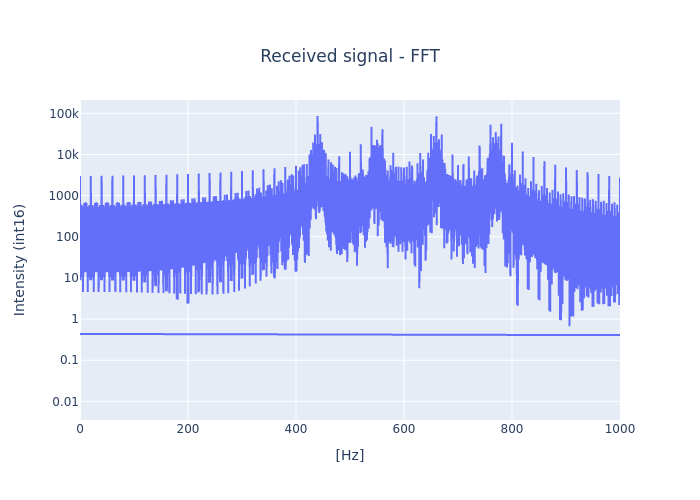

GRAFICO INTERATIVO CORRESPONDENTE: recv__fft_mvAvg100_seq6_nSymbols4_Ts50ms.html


In [9]:
# Open Audio File
sampleRate, receivedData = wavfile.read("audios/" + audioFile)

if (receivedData.dtype == 'int16'):
    receivedData = receivedData / float(2**15)

if plot:
    fftSignal = np.abs(np.fft.fft(receivedData))
    ft = np.fft.fftfreq(len(receivedData),1/(sampleRate))

    fig = go.Figure()
    fig.add_trace(go.Scatter(y=fftSignal,
                             x=ft,
                        name='fft'))
    fig.update_xaxes(range=[0, 1000])
    fig.update_yaxes(type="log")
    fig.update_layout(
        title={'text': "Received signal - FFT",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        yaxis_title="Intensity (int16)",
        xaxis_title="[Hz]",
    )

    figname = "recv__fft_mvAvg{}_seq{}_nSymbols{}_Ts{}ms.html".format(w, nSequencer, nSymbols, int(Ts*1000))
    plotly.offline.plot(fig, filename = "graficos/" + figname, auto_open=False)
    fig.show(renderer="png")
    print("GRAFICO INTERATIVO CORRESPONDENTE: {}".format(figname))

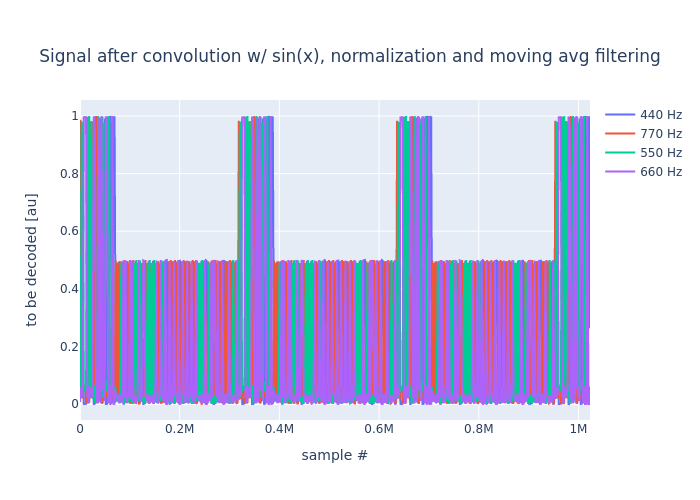

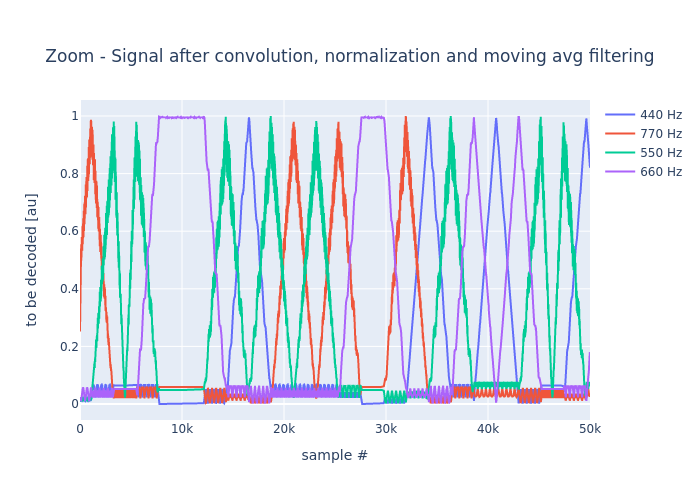

GRAFICO INTERATIVO CORRESPONDENTE: recv_mvAvg100_seq6_nSymbols4_Ts50ms.html


In [11]:
# Filter h(t) == senoides representativas de cada simbolo
# Convolucao com h(t) e valor absoluto
rt = []
for sinf in symbolMapping[nSymbols].keys():
    rt.append(abs(np.convolve(receivedData, symbolMapping[nSymbols][sinf], mode='same')))


# APLICACAO DA MEDIA MOVEL E NORMALIZACAO
mt = []
for r in rt:
    movingAvg = np.convolve(r,mAvg,mode='same')
    mt.append(movingAvg/max(movingAvg))


if plot:
    fig = go.Figure()
    tx=np.linspace(0, len(mt[0])/sampleRate, len(mt[0]))
    for i in range(len(f)):
        fig.add_trace(go.Scatter(y=mt[i],
                              #  x=tx,
                            name='{} Hz'.format(f[i])))

    fig.update_layout(
        title={
            'text': "Signal after convolution w/ sin(x), normalization and moving avg filtering",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        yaxis_title="to be decoded [au]",
        xaxis_title="sample #",
    )
    fig.show(renderer="png")
    figname = "recv_mvAvg{}_seq{}_nSymbols{}_Ts{}ms.html".format(w, nSequencer, nSymbols, int(Ts*1000))
    plotly.offline.plot(fig, filename = "graficos/" + figname, auto_open=False)
    
    
    fig = go.Figure()
    tx=np.linspace(0, len(mt[0])/sampleRate, len(mt[0]))
    for i in range(len(f)):
        fig.add_trace(go.Scatter(y=mt[i][:50000],
                              #  x=tx,
                            name='{} Hz'.format(f[i])))

    fig.update_layout(
        title={
            'text': "Zoom - Signal after convolution, normalization and moving avg filtering",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        yaxis_title="to be decoded [au]",
        xaxis_title="sample #",
    )
    fig.show(renderer="png")

    
    
    print("GRAFICO INTERATIVO CORRESPONDENTE: {}".format(figname))

---
Sequencialmente, precisa se definir o ponto inicial de amostragem do sinal e, a cada tempo de símbolo, amostrar novamente para compor a sequencia de bits.

A estratégia definida e utilizada é encontrar o índice do ponto médio de transição entre 0 e 1 de um dos sinais. Assim, adiciona-se metade do tempo de símbolo para ter o momento mais adequado da primeira amostra do sinal.

A cada amostragem, a sequencia de bits é construída com base no símbolo com maior amplitude.

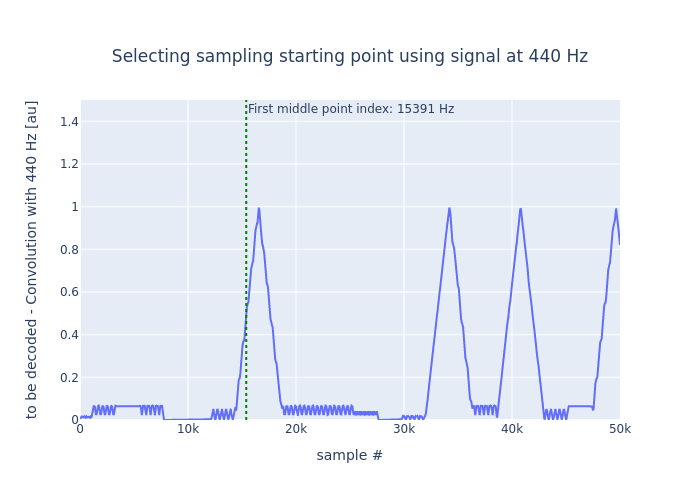

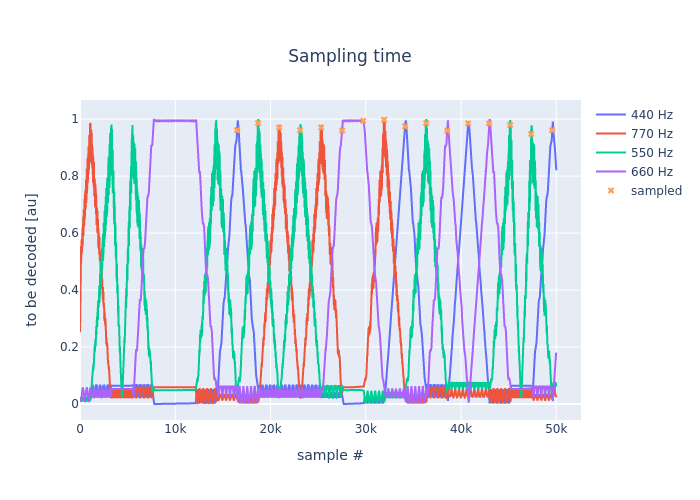

GRAFICO INTERATIVO CORRESPONDENTE: recv_mvAvg100_sampling_seq6_nSymbols4_Ts50ms.html


TOTAL DE BITS DECODIFICADOS: 914
SEQUENCIA DECODIFICADA: b'00110111011010010011100010111100101000110000100000010101000111001001100001011011100111001101101101011010010111001101110011011000010110111100100000011001000110010100100000011001000110000101100100011011110111001100100000011101100110100101100001001000000100011001010011010010110111111010101100110111011010010011100010111100101000110000100000010101000111001001100001011011100111001101101101011010010111001101110011011000010110111100100000011001000110010100100000011001000110000101100100011011110111001100100000011101100110100101100001001000000100011001010011010010110111111010101100110111011010010011100010111100101000110000100000010101000111001001100001011011100111001101101101011010010111001101110011011000010110111100100000011001000110010100100000011001000110000101100100011011110111001100100000011101100110100101100001001000000100011001010011010010110111

In [17]:
# INDICE INICIAL PARA AMOSTRAGEM
initialValue = mt[0][0]

for idx in range(len(mt[0])):
    if(initialValue > 0.5):
        if(mt[0][idx] < 0.5):
            firstIndex = int(idx + Ts*sampleRate/2)
            break
    else:
        if(mt[0][idx] > 0.5):
            firstIndex = int(idx + Ts*sampleRate/2)
            break


# CRIA ARRAY DE BITS
incomingBits = b''
evaluateIndex = firstIndex
sampleIndex = []
sampleValue = []

while (evaluateIndex < len(mt[0])):
    sampleIndex.append(evaluateIndex)
    if(nSymbols == 2):
        if(mt[0][evaluateIndex] > mt[1][evaluateIndex]):
            incomingBits += b'0'
            sampleValue.append(mt[0][evaluateIndex])
        else:
            incomingBits += b'1'
            sampleValue.append(mt[1][evaluateIndex])


    elif(nSymbols == 4):
        maxValue = 0
        for m in mt:
            maxValue = max(m[evaluateIndex],maxValue)
        sampleValue.append(maxValue)
        
        for i in range(len(mt)):
            if maxValue == mt[i][evaluateIndex]:
                incomingBits += receivedSymbolMapping[nSymbols][i]
    evaluateIndex += int(sampleRate*Ts)



if plot:
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=mt[0][:50000],
                            name='{} Hz'.format(f[0])))
        
    fig.add_vline(x=firstIndex-Ts*sampleRate/2, 
                  line_dash="dot", 
                  annotation_text="First middle point index: {} Hz".format(int(firstIndex-Ts*sampleRate/2)), 
                  line_color="green")
    fig.update_layout(
        title={
            'text': "Selecting sampling starting point using signal at {} Hz".format(f[0]),
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        yaxis_title=" to be decoded - Convolution with {} Hz [au]".format(f[0]),
        xaxis_title="sample #",
    )
    fig.update_yaxes(range=[0, 1.5])
    fig.show(renderer="png")
    
    
    fig = go.Figure()
    for i in range(len(f)):
        fig.add_trace(go.Scatter(y=mt[i][:50000],
                            name='{} Hz'.format(f[i])))
    
    fig.add_trace(go.Scatter(x=sampleIndex[:16], y=sampleValue[:16],
                    mode='markers', name='sampled', marker_symbol='x'))

    fig.update_layout(
        title={
            'text': " Sampling time",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        yaxis_title="to be decoded [au]",
        xaxis_title="sample #",
    )
    fig.show(renderer="png")
    
    fig = go.Figure()
    for i in range(len(f)):
        fig.add_trace(go.Scatter(y=mt[i],
                            name='{} Hz'.format(f[i])))
    
    fig.add_trace(go.Scatter(x=sampleIndex, y=sampleValue,
                    mode='markers', name='sampled', marker_symbol='x'))

    fig.update_layout(
        title={
            'text': " Sampling time - Processed signal",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        yaxis_title="to be decoded [au]",
        xaxis_title="sample #",
    )
    figname = "recv_mvAvg{}_sampling_seq{}_nSymbols{}_Ts{}ms.html".format(w, nSequencer, nSymbols, int(Ts*1000))
    plotly.offline.plot(fig, filename = "graficos/" + figname, auto_open=False)
    print("GRAFICO INTERATIVO CORRESPONDENTE: {}".format(figname))
    
    
print("")
print("")
print("TOTAL DE BITS DECODIFICADOS: {}".format(len(incomingBits)))
print("SEQUENCIA DECODIFICADA: {}".format(incomingBits))

---
Tendo a sequência de bits formada, é necessário a busca pela sequência de treinamento a fim de se definir o início dos bits úteis da mensagem para decodificá-los.

Isso será feito com base no critério de distância mínima, onde percorre-se a sequência de bits avaliando e comparando com os bits esperados. A distância é definida como a quantidade de total de bits que divergem em ambas as sequências, de treinamento e da fatia de bits em análise.

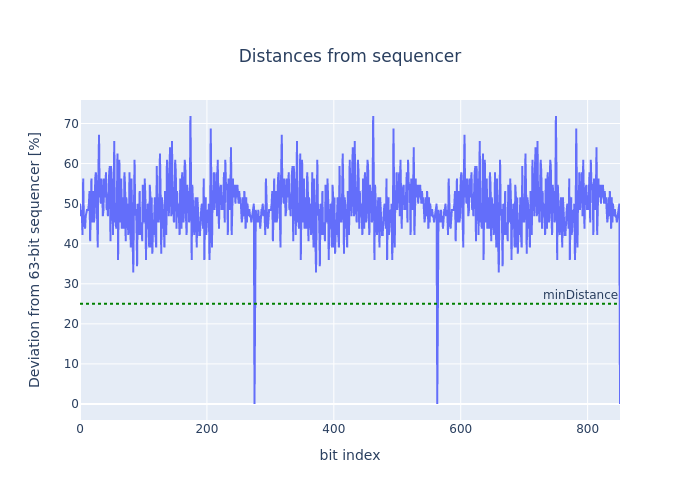

GRAFICO INTERATIVO CORRESPONDENTE: recv_distances_mvAvg100_sampling_seq6_nSymbols4_Ts50ms.html


In [31]:
# FIND SEQUENCER DELIMITATION INDEX - MINIMAL DISTANCE METHOD
minIndex = []
distances = []

for i in range(len(incomingBits) - nbitsSequencer + 1):
    recebidoInt = int(incomingBits[i:i+nbitsSequencer],2)
    normalizedDistances = (float(bin(recebidoInt ^ seqIntValue).count("1"))) / (2**nSequencer)
    distances.append(normalizedDistances*100)
    if normalizedDistances < minDistanceAccepted:
        minIndex.append(i)
        

if plot:
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=distances))
    
    fig.add_hline(y=minDistanceAccepted*100, 
                  line_dash="dot", 
                  annotation_text="minDistance", 
                  line_color="green")


    fig.update_layout(
        title={
            'text': "Distances from sequencer",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        yaxis_title="Deviation from {}-bit sequencer [%]".format(2**nSequencer-1),
        xaxis_title="bit index",
    )
    figname = "recv_distances_mvAvg{}_sampling_seq{}_nSymbols{}_Ts{}ms.html".format(w, nSequencer, nSymbols, int(Ts*1000))
    plotly.offline.plot(fig, filename = "graficos/" + figname, auto_open=False)
    fig.show(renderer="png")
    print("GRAFICO INTERATIVO CORRESPONDENTE: {}".format(figname))    

---
Finalmente, extrai-se a(s) mensagens(s) que se encontram entre as sequencias de treinamento:

In [35]:
# QUANTIDADE DE SEQUENCIAS RECEBIDAS
decodedMessage = {}
receivedSequences = len(minIndex) - 1


# INFORMACOES DE CADA SEQUENCIA
for i in range(receivedSequences): 
    decodedMessage[i] = {'payloadIndex': minIndex[i]+nbitsSequencer,
                         'payloadBytes': int(len(incomingBits[minIndex[i]+nbitsSequencer:minIndex[i+1]])/8),
                         'receivedMessage': ""}

# DECODIFICACAO DA MENSAGEM ASCII
for sequence in decodedMessage.keys():
    idx = decodedMessage[sequence]['payloadIndex']
    for n in range(decodedMessage[sequence]['payloadBytes']):
        byte = incomingBits[idx+8*n:idx+8*n+8]
        caracter = (chr(int(byte,2)))
        decodedMessage[sequence]['receivedMessage'] += caracter



print("SEQUENCIAS DE TREINAMENTO ENCONTRADAS: {}".format(len(minIndex)))
print("")
print("")

for msg in (decodedMessage.keys()):
    print("----- Mensagem #{}".format(msg+1))
    print("Index inicial: {}".format(decodedMessage[msg]["payloadIndex"]))
    print("Quantidade de caracteres: {}".format(decodedMessage[msg]["payloadBytes"]))
    print("Mensagem: {}".format(decodedMessage[msg]["receivedMessage"]))
    print("")

SEQUENCIAS DE TREINAMENTO ENCONTRADAS: 3


----- Mensagem #1
Index inicial: 338
Quantidade de caracteres: 28
Mensagem: Transmissao de dados via FSK

----- Mensagem #2
Index inicial: 626
Quantidade de caracteres: 28
Mensagem: Transmissao de dados via FSK



---
Nota-se que, por conta da estratégia de decodificação, envio de informação e sincronização de recebimento, a primeira *sequência de treinamento + mensagem* acaba sendo descartada por não ser identificada no critério de distância mínima.

---
## Recepção - Gravação externa



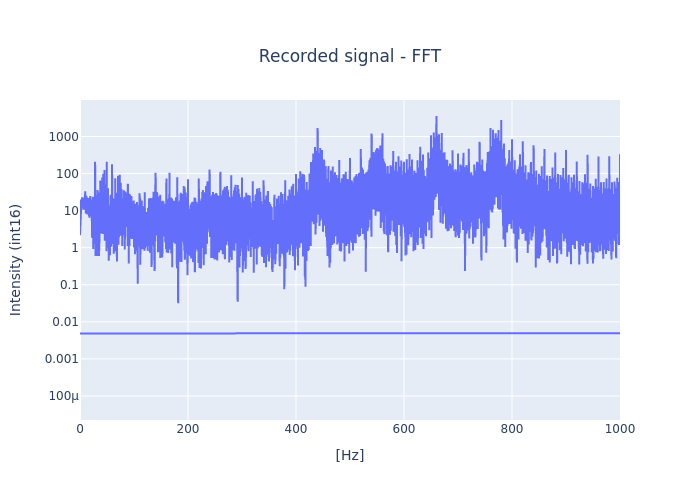

GRAFICO INTERATIVO CORRESPONDENTE: recorded_fft_mvAvg100_seq6_nSymbols4_Ts50ms.html


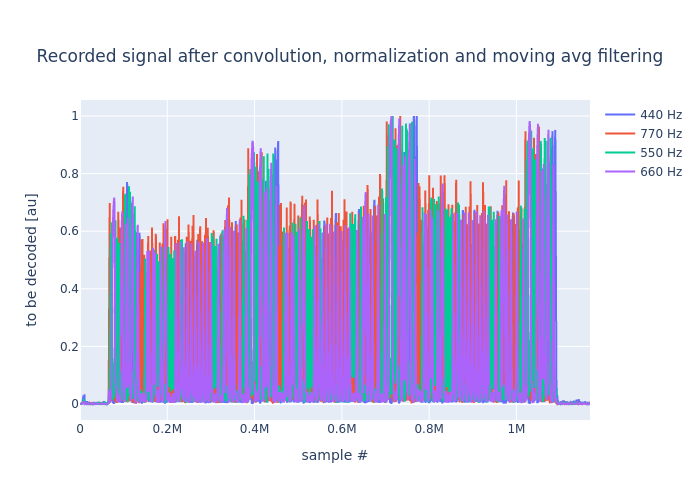

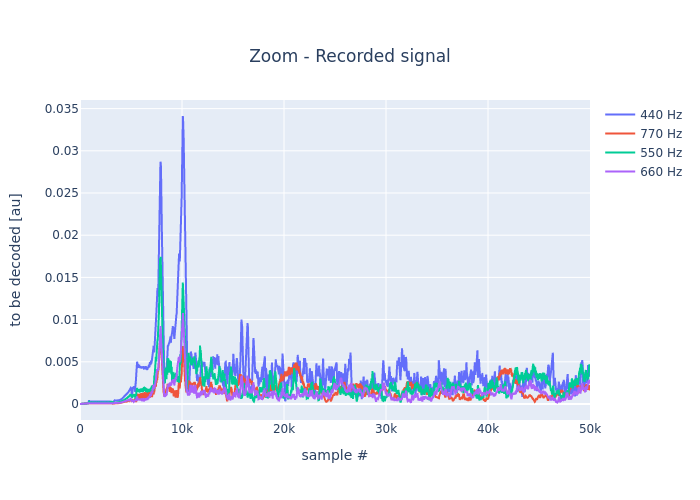

GRAFICO INTERATIVO CORRESPONDENTE: recorded_mvAvg100_seq6_nSymbols4_Ts50ms.html


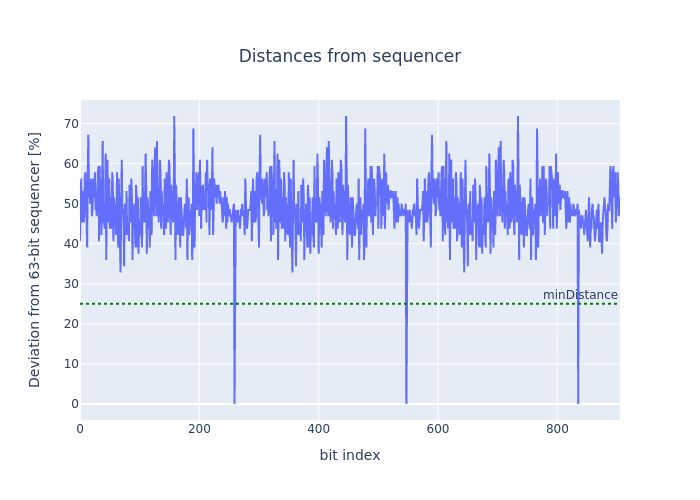

GRAFICO INTERATIVO CORRESPONDENTE: recorded_distances_mvAvg100_sampling_seq6_nSymbols4_Ts50ms.html
GRAVACAO - SEQUENCIAS DE TREINAMENTO ENCONTRADAS: 3


----- Mensagem #1
Index inicial: 322
Quantidade de caracteres: 28
Mensagem: Transmissao de dados via FSI
----- Mensagem #2
Index inicial: 610
Quantidade de caracteres: 28
Mensagem: Transmissao de dados via FSI


In [4]:
# Open Audio File
sampleRate, receivedData = wavfile.read("audios/" + "gravacao.wav")

if (receivedData.dtype == 'int16'):
    receivedData = receivedData / float(2**15)

if plot:
    fftSignal = np.abs(np.fft.fft(receivedData))
    ft = np.fft.fftfreq(len(receivedData),1/(sampleRate))

    fig = go.Figure()
    fig.add_trace(go.Scatter(y=fftSignal,
                             x=ft,
                        name='fft'))
    fig.update_xaxes(range=[0, 1000])
    fig.update_yaxes(type="log")
    fig.update_layout(
        title={'text': "Recorded signal - FFT",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        yaxis_title="Intensity (int16)",
        xaxis_title="[Hz]",
    )

    figname = "recorded_fft_mvAvg{}_seq{}_nSymbols{}_Ts{}ms.html".format(w, nSequencer, nSymbols, int(Ts*1000))
    plotly.offline.plot(fig, filename = figname, auto_open=False)
    fig.show(renderer="png")
    print("GRAFICO INTERATIVO CORRESPONDENTE: {}".format(figname))
    
    
    
# Filter h(t) == senoides representativas de cada simbolo
# Convolucao com h(t) e valor absoluto
rt = []
for sinf in symbolMapping[nSymbols].keys():
    rt.append(abs(np.convolve(receivedData, symbolMapping[nSymbols][sinf], mode='same')))


# APLICACAO DA MEDIA MOVEL E NORMALIZACAO
mt = []
for r in rt:
    movingAvg = np.convolve(r,mAvg,mode='same')
    mt.append(movingAvg/max(movingAvg))


if plot:
    fig = go.Figure()
    tx=np.linspace(0, len(mt[0])/sampleRate, len(mt[0]))
    for i in range(len(f)):
        fig.add_trace(go.Scatter(y=mt[i],
                            name='{} Hz'.format(f[i])))

    fig.update_layout(
        title={
            'text': "Recorded signal after convolution, normalization and moving avg filtering",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        yaxis_title="to be decoded [au]",
        xaxis_title="sample #",
    )
    fig.show(renderer="png")
    figname = "recorded_mvAvg{}_seq{}_nSymbols{}_Ts{}ms.html".format(w, nSequencer, nSymbols, int(Ts*1000))
    plotly.offline.plot(fig, filename = figname, auto_open=False)
    
    
    fig = go.Figure()
    tx=np.linspace(0, len(mt[0])/sampleRate, len(mt[0]))
    for i in range(len(f)):
        fig.add_trace(go.Scatter(y=mt[i][:50000],
                            name='{} Hz'.format(f[i])))

    fig.update_layout(
        title={
            'text': "Zoom - Recorded signal",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        yaxis_title="to be decoded [au]",
        xaxis_title="sample #",
    )
    fig.show(renderer="png")
    
    print("GRAFICO INTERATIVO CORRESPONDENTE: {}".format(figname))
    
    
# INDICE INICIAL PARA AMOSTRAGEM
initialValue = mt[0][0]

for idx in range(len(mt[0])):
    if(initialValue > 0.5):
        if(mt[0][idx] < 0.5):
            firstIndex = int(idx + Ts*sampleRate/2)
            break
    else:
        if(mt[0][idx] > 0.5):
            firstIndex = int(idx + Ts*sampleRate/2)
            break


# CRIA ARRAY DE BITS
incomingBits = b''
evaluateIndex = firstIndex
sampleIndex = []
sampleValue = []

while (evaluateIndex < len(mt[0])):
    sampleIndex.append(evaluateIndex)
    if(nSymbols == 2):
        if(mt[0][evaluateIndex] > mt[1][evaluateIndex]):
            incomingBits += b'0'
            sampleValue.append(mt[0][evaluateIndex])
        else:
            incomingBits += b'1'
            sampleValue.append(mt[1][evaluateIndex])


    elif(nSymbols == 4):
        maxValue = 0
        for m in mt:
            maxValue = max(m[evaluateIndex],maxValue)
        sampleValue.append(maxValue)
        
        for i in range(len(mt)):
            if maxValue == mt[i][evaluateIndex]:
                incomingBits += receivedSymbolMapping[nSymbols][i]
    evaluateIndex += int(sampleRate*Ts)



if plot:    
    fig = go.Figure()
    for i in range(len(f)):
        fig.add_trace(go.Scatter(y=mt[i],
                            name='{} Hz'.format(f[i])))
    
    fig.add_trace(go.Scatter(x=sampleIndex, y=sampleValue,
                    mode='markers', name='sampled', marker_symbol='x'))

    fig.update_layout(
        title={
            'text': " Sampling time - Processed signal",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        yaxis_title="to be decoded [au]",
        xaxis_title="sample #",
    )
    figname = "recorded_mvAvg{}_sampling_seq{}_nSymbols{}_Ts{}ms.html".format(w, nSequencer, nSymbols, int(Ts*1000))
    plotly.offline.plot(fig, filename = figname, auto_open=False)
    


# FIND SEQUENCER DELIMITATION INDEX - MINIMAL DISTANCE METHOD
minIndex = []
distances = []

for i in range(len(incomingBits) - nbitsSequencer + 1):
    recebidoInt = int(incomingBits[i:i+nbitsSequencer],2)
    normalizedDistances = (float(bin(recebidoInt ^ seqIntValue).count("1"))) / (2**nSequencer)
    distances.append(normalizedDistances*100)
    if normalizedDistances < minDistanceAccepted:
        minIndex.append(i)
        

if plot:
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=distances))
    
    fig.add_hline(y=minDistanceAccepted*100, 
                  line_dash="dot", 
                  annotation_text="minDistance", 
                  line_color="green")


    fig.update_layout(
        title={
            'text': "Distances from sequencer",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        yaxis_title="Deviation from {}-bit sequencer [%]".format(2**nSequencer-1),
        xaxis_title="bit index",
    )
    figname = "recorded_distances_mvAvg{}_sampling_seq{}_nSymbols{}_Ts{}ms.html".format(w, nSequencer, nSymbols, int(Ts*1000))
    plotly.offline.plot(fig, filename = figname, auto_open=False)
    fig.show(renderer="png")
    print("GRAFICO INTERATIVO CORRESPONDENTE: {}".format(figname))  
    
    
# QUANTIDADE DE SEQUENCIAS RECEBIDAS
decodedMessage = {}
receivedSequences = len(minIndex) - 1


# INFORMACOES DE CADA SEQUENCIA
for i in range(receivedSequences): 
    decodedMessage[i] = {'payloadIndex': minIndex[i]+nbitsSequencer,
                         'payloadBytes': int(len(incomingBits[minIndex[i]+nbitsSequencer:minIndex[i+1]])/8),
                         'receivedMessage': ""}

# DECODIFICACAO DA MENSAGEM ASCII
for sequence in decodedMessage.keys():
    idx = decodedMessage[sequence]['payloadIndex']
    for n in range(decodedMessage[sequence]['payloadBytes']):
        byte = incomingBits[idx+8*n:idx+8*n+8]
        caracter = (chr(int(byte,2)))
        decodedMessage[sequence]['receivedMessage'] += caracter



print("GRAVACAO - SEQUENCIAS DE TREINAMENTO ENCONTRADAS: {}".format(len(minIndex)))
print("")
print("")

for msg in (decodedMessage.keys()):
    print("----- Mensagem #{}".format(msg+1))
    print("Index inicial: {}".format(decodedMessage[msg]["payloadIndex"]))
    print("Quantidade de caracteres: {}".format(decodedMessage[msg]["payloadBytes"]))
    print("Mensagem: {}".format(decodedMessage[msg]["receivedMessage"]))

---
#### Observações

Nota-se que há um "flip" de bit na mensagem decodificada. Tal erro se deve ao fato de que a estratégia para detecção do tempo de amostragem não é a ideal, uma vez que o tempo de subida e descida não é equivalente para o sinal trafegando num canal real, como mostrado nas imagens abaixo.

Isso ocasiona a amostragem de outro símbolo, fazendo com que decodificasse **"11"** ao invés de **"01"** (I -> J -> K).

Seria possível:
* Definir outra estratégia para identificar o índice de amostragem
* Encontrar os "picos" do sinal antes de amostrá-lo e não apenas iterar os índices.

<br>

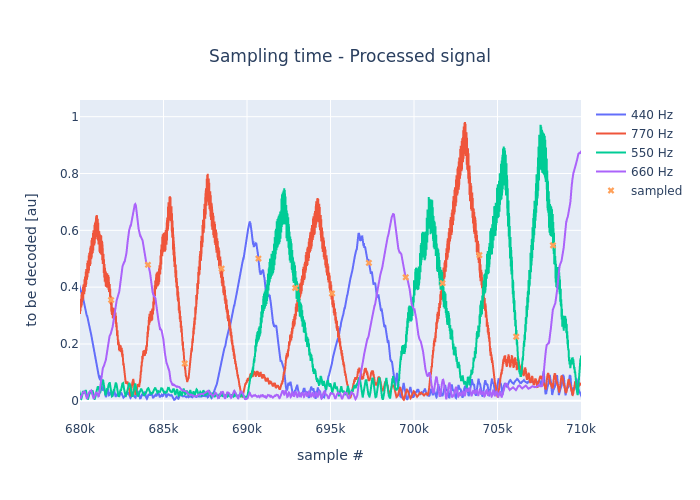

GRAFICO INTERATIVO CORRESPONDENTE: recorded_mvAvg100_sampling_seq6_nSymbols4_Ts50ms.html


In [5]:
if plot:    
    fig = go.Figure()
    for i in range(len(f)):
        fig.add_trace(go.Scatter(y=mt[i],
                            name='{} Hz'.format(f[i])))
    
    fig.add_trace(go.Scatter(x=sampleIndex, y=sampleValue,
                    mode='markers', name='sampled', marker_symbol='x'))

    fig.update_layout(
        title={
            'text': " Sampling time - Processed signal",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        yaxis_title="to be decoded [au]",
        xaxis_title="sample #",
    )
    fig.update_xaxes(range=[680000, 710000])
    fig.show(renderer="png")
    figname = "recorded_mvAvg{}_sampling_seq{}_nSymbols{}_Ts{}ms.html".format(w, nSequencer, nSymbols, int(Ts*1000))
    print("GRAFICO INTERATIVO CORRESPONDENTE: {}".format(figname))




Como correção, adiciona-se *0.3 * tempo de bit* (ao invés de 0.5) ao índice inicial. Assim, tem-se as amostragens em momentos mais assertivos.

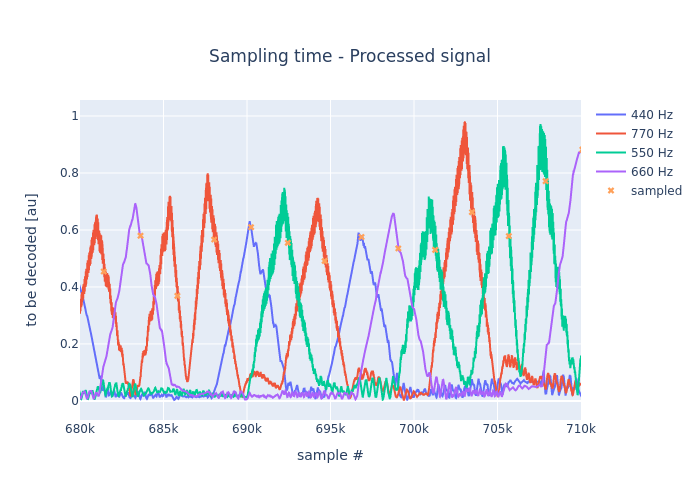

GRAVACAO - SEQUENCIAS DE TREINAMENTO ENCONTRADAS: 3


----- Mensagem #1
Index inicial: 322
Quantidade de caracteres: 28
Mensagem: Transmissao de dados via FSK
----- Mensagem #2
Index inicial: 610
Quantidade de caracteres: 28
Mensagem: Transmissao de dados via FSK


In [5]:
# INDICE INICIAL PARA AMOSTRAGEM
initialValue = mt[0][0]

for idx in range(len(mt[0])):
    if(initialValue > 0.5):
        if(mt[0][idx] < 0.5):
            firstIndex = int(idx + Ts*sampleRate*0.3)
            break
    else:
        if(mt[0][idx] > 0.5):
            firstIndex = int(idx + Ts*sampleRate*0.3)
            break


# CRIA ARRAY DE BITS
incomingBits = b''
evaluateIndex = firstIndex
sampleIndex = []
sampleValue = []

while (evaluateIndex < len(mt[0])):
    sampleIndex.append(evaluateIndex)
    if(nSymbols == 2):
        if(mt[0][evaluateIndex] > mt[1][evaluateIndex]):
            incomingBits += b'0'
            sampleValue.append(mt[0][evaluateIndex])
        else:
            incomingBits += b'1'
            sampleValue.append(mt[1][evaluateIndex])


    elif(nSymbols == 4):
        maxValue = 0
        for m in mt:
            maxValue = max(m[evaluateIndex],maxValue)
        sampleValue.append(maxValue)
        
        for i in range(len(mt)):
            if maxValue == mt[i][evaluateIndex]:
                incomingBits += receivedSymbolMapping[nSymbols][i]
    evaluateIndex += int(sampleRate*Ts)

# FIND SEQUENCER DELIMITATION INDEX - MINIMAL DISTANCE METHOD
minIndex = []
distances = []

for i in range(len(incomingBits) - nbitsSequencer + 1):
    recebidoInt = int(incomingBits[i:i+nbitsSequencer],2)
    normalizedDistances = (float(bin(recebidoInt ^ seqIntValue).count("1"))) / (2**nSequencer)
    distances.append(normalizedDistances*100)
    if normalizedDistances < minDistanceAccepted:
        minIndex.append(i)    
    
# QUANTIDADE DE SEQUENCIAS RECEBIDAS
decodedMessage = {}
receivedSequences = len(minIndex) - 1


# INFORMACOES DE CADA SEQUENCIA
for i in range(receivedSequences): 
    decodedMessage[i] = {'payloadIndex': minIndex[i]+nbitsSequencer,
                         'payloadBytes': int(len(incomingBits[minIndex[i]+nbitsSequencer:minIndex[i+1]])/8),
                         'receivedMessage': ""}

# DECODIFICACAO DA MENSAGEM ASCII
for sequence in decodedMessage.keys():
    idx = decodedMessage[sequence]['payloadIndex']
    for n in range(decodedMessage[sequence]['payloadBytes']):
        byte = incomingBits[idx+8*n:idx+8*n+8]
        caracter = (chr(int(byte,2)))
        decodedMessage[sequence]['receivedMessage'] += caracter


if plot:    
    fig = go.Figure()
    for i in range(len(f)):
        fig.add_trace(go.Scatter(y=mt[i],
                            name='{} Hz'.format(f[i])))
    
    fig.add_trace(go.Scatter(x=sampleIndex, y=sampleValue,
                    mode='markers', name='sampled', marker_symbol='x'))

    fig.update_layout(
        title={
            'text': " Sampling time - Processed signal",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        yaxis_title="to be decoded [au]",
        xaxis_title="sample #",
    )
    fig.update_xaxes(range=[680000, 710000])
    fig.show(renderer="png")
        

print("GRAVACAO - SEQUENCIAS DE TREINAMENTO ENCONTRADAS: {}".format(len(minIndex)))
print("")
print("")

for msg in (decodedMessage.keys()):
    print("----- Mensagem #{}".format(msg+1))
    print("Index inicial: {}".format(decodedMessage[msg]["payloadIndex"]))
    print("Quantidade de caracteres: {}".format(decodedMessage[msg]["payloadBytes"]))
    print("Mensagem: {}".format(decodedMessage[msg]["receivedMessage"]))

---
## Considerações

#### Transmissor
* Uma estratégia para melhorar a detecção da sequencia de treinamento é aumentar a amplitude dos símbolos que a representa em relação aos símbolos dos caracteres.
<br>

#### Receptor
* Uma das maiores dificuldades é encontrar o momento exato para amostragem em canais não-ideais (sincronismo) e mantê-lo com a mínima necessidade de um novo treinamento.
* O canal de transmissão não-ideal pode não só adicionar ruído (branco ou não) ao sinal, mas também causar variações da frequência da portadora.
* Um algoritmo de recuperação de dado (CRC, hamming, etc) pode auxiliar no caso de flip de bits.
<br>

#### Globais
* Seria possível reduzir o tempo de símbolo se trabalhássemos com frequências mais altas, saindo do espectro sonoro, mas ainda dentro da faixa da taxa de amostragem (por Nyquist, até 22 kHz. Mas idealmente menos que isso, 4 kHz.)
<br>